# 11: Neural networks and deep learning

The hand-in exercise for this topic is Exercise 2 from the notebook “Exercises in neural network and deep learning II.ipynb”

Exercise 2

Based on the adult dataset, build a neural network classifier for the target variable income.

### Assemble + Installs + Imports

In [1]:
# Lib imports for the notebook
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Since we are working with the adult dataset, we need to clean up the income categories so none of the rows contain a trailing period in the feature. 


In [2]:
# read the csv
adult_data = pd.read_csv("adult.csv")

### Initial EDA

In [3]:
# To do this lets first see how many different values income currently holds
adult_data['income'].value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [4]:

# Lets merge the the values into only 2 categories by trimming dots in the column entries
adult_data["income"] = adult_data["income"].str.replace(".", "")
# Lets see if it worked
adult_data['income'].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [5]:
adult_data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [6]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


---

### Exercise 2

Based on the **adult dataset**, build a neural network classifier for the target variable 'income'.

### Data Prep

To do this i will need to preprocess the data

In [7]:
# First of all lets check for missing values
adult_data.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [8]:
# Since there are some missing categorical values, we are going to fill them in with the most common category of its column
categorical_columns = adult_data.select_dtypes(include=['object']).columns
adult_data[categorical_columns] = adult_data[categorical_columns].fillna(adult_data[categorical_columns].mode().iloc[0])
# Check result
adult_data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

---

### Encode the 'income' feature

I encode the 'income' feature so its understandable for MLM and Neural Networks. These models require a numerical input and might fail with the original >50k and <=50k

In [9]:
# Init labe encoder and apply it to income
label_encoder = LabelEncoder()
adult_data['income'] = label_encoder.fit_transform(adult_data['income'])

### Specify Feature and Target variables

Im going to sepperate numeric and categorical here, as they should be prepped differently...

In [10]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = [col for col in categorical_columns if col != 'income']

In [11]:
# Transform them in each their way
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

Initialize a train test split and pre process the data

In [12]:
X = adult_data.drop(columns=['income'])
y = adult_data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Build a neural network using keras library

In [14]:
model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/50
489/489 [==============================] - 1s 1ms/step - loss: 0.4292 - accuracy: 0.8139 - val_loss: 0.3254 - val_accuracy: 0.8495
Epoch 2/50
489/489 [==============================] - 1s 1ms/step - loss: 0.3216 - accuracy: 0.8511 - val_loss: 0.3159 - val_accuracy: 0.8566
Epoch 3/50
489/489 [==============================] - 1s 1ms/step - loss: 0.3158 - accuracy: 0.8517 - val_loss: 0.3141 - val_accuracy: 0.8567
Epoch 4/50
489/489 [==============================] - 0s 964us/step - loss: 0.3136 - accuracy: 0.8544 - val_loss: 0.3109 - val_accuracy: 0.8575
Epoch 5/50
489/489 [==============================] - 0s 910us/step - loss: 0.3112 - accuracy: 0.8555 - val_loss: 0.3092 - val_accuracy: 0.8591
Epoch 6/50
489/489 [==============================] - 0s 955us/step - loss: 0.3096 - accuracy: 0.8551 - val_loss: 0.3084 - val_accuracy: 0.8605
Epoch 7/50
489/489 [==============================] - 1s 2ms/step - loss: 0.3080 - accuracy: 0.8562 - val_loss: 0.3071 - val_accuracy: 0.8614


### Evaluation of the neural network model:

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy: ' + str((test_acc * 100)) + '%')

306/306 [==============================] - 0s 1ms/step - loss: 0.3173 - accuracy: 0.8575
Test Accuracy: 85.75084209442139%


### Validation loss

* As seen in the epochs the validation of the model rises over time where the training loss falls over time 
* This can also be clearly visualized using a plot

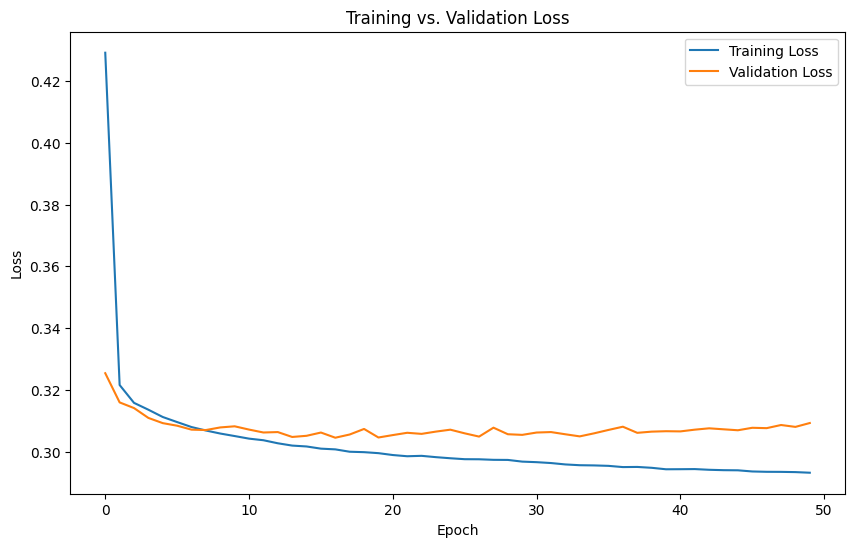

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

looking at this model, we start with a high training loss, which drops rapidly, this is as expected, especially as it keeps decreasing over time. 

secondly looking at the validation loss, it has no clear overfitting, though it curves upwards after around 10  epochs which tells us it doesnt need 50 epochs, but around 10 would suffice 